# Statistics studies

<br>
Created: 03.01.2024<br>
Melih Kara

Following the same lecture, practicing statistics. <br>
https://indico.desy.de/event/38671/contributions/140932/attachments/83039/109605/2023_07_03_Statisticsschool_DESY_with_solutions.pdf

In [17]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import uproot
import scipy
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

In [2]:
rootfile = uproot.open("./StatTutorial-master/data/Histograms_fake.root")
higgs_expected = rootfile['h_m4l_Higgs125_fake;1'].to_numpy()
bg_expected = rootfile['h_m4l_ZZ_fake;1'].to_numpy()
observed_data = rootfile['h_m4l_data_fake;1'].to_numpy()

energies = higgs_expected[1][1:]
higgs_expected = higgs_expected[0]
bg_expected = bg_expected[0]
observed_data = observed_data[0]
energies.shape, higgs_expected.shape, bg_expected.shape, observed_data.shape

((3600,), (3600,), (3600,), (3600,))

In [3]:
# rebinned data
rb_energies = energies.reshape((180,20)).mean(1)
rb_observed_data = observed_data.reshape((180,20)).sum(1)
rb_higgs_expected = higgs_expected.reshape((180,20)).sum(1)
rb_bg_expected = bg_expected.reshape((180,20)).sum(1)

In [4]:
optimized_window = 7.26 # GeV for luminosity scale factor of 1
alpha_scale = 1.11 # for background model scaling 
sigma_p = 0.063
sigma_m = 0.075
ROI = (energies >= 125-optimized_window/2) & (energies <= 125+optimized_window/2)

$$f_{total} = \mu\cdot f_{\rm Higgs} + \alpha\cdot f_{\rm SM}$$<br>
 $$-2\log(L) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}|\lambda))$$<br>
 $$\alpha = 1.11^{+0.075}_{-0.063}$$<br>
 
 Now we are ready to move on!

We first need to estimate the expected background and its uncertainty within an optimized window around our signal region.

In [5]:
roi_energies = energies[ROI] 
roi_unscaled_bg_expected = bg_expected[ROI]
roi_bg_expected = bg_expected[ROI] * alpha_scale # scale bg expectation
roi_higgs_expected = higgs_expected[ROI] # should you scale the signal expectation as well?
roi_observed_data = observed_data[ROI]

print("Expected Higgs Counts:", np.sum(roi_higgs_expected))
print("Expected BG Counts", np.sum(roi_bg_expected))
print("Expected BG Counts (Unscaled)", np.sum(roi_unscaled_bg_expected))
print("Observed Total", np.sum(roi_observed_data))

Expected Higgs Counts: 5.384098
Expected BG Counts 4.9666247
Expected BG Counts (Unscaled) 4.4744368
Observed Total 13.0


In [6]:
print(f"Expected BG Counts (Scaled) {np.sum(roi_bg_expected):.2f} +{np.sum(roi_unscaled_bg_expected)*sigma_p:.2f}, -{np.sum(roi_unscaled_bg_expected)*sigma_m:.2f}")

Expected BG Counts (Scaled) 4.97 +0.28, -0.34


Now, based on these expectations we can compute a p-value and a significance. <br>
What is the Poisson probability of observing 13 events, when you expect 4.97+/-sigma

In [7]:
mu_norm = 0
normal_dist = ss.norm(mu_norm)
x = np.linspace(-5,5,10000)
normal_pdf = normal_dist.pdf(x)

pvaltosigma = lambda p: abs(normal_dist.ppf(p))
sigmatopval = lambda s: 1-normal_dist.cdf(s)

In [8]:
lmb_1 = np.sum(bg_expected[ROI] * (alpha_scale-sigma_m))
lmb_2 = np.sum(bg_expected[ROI] * (alpha_scale+sigma_m))

pval_1 = ss.poisson(lmb_1).pmf(np.sum(roi_observed_data).astype(int))
sigma_1 = pvaltosigma(pval_1)

pval_2 = ss.poisson(lmb_2).pmf(np.sum(roi_observed_data).astype(int))
sigma_2 = pvaltosigma(pval_2)

print(fr"P({np.sum(roi_observed_data).astype(int)}|{int(lmb_1)})={pval_1:.5f}, =={sigma_1:.2f} sigma")
print(fr"P({np.sum(roi_observed_data).astype(int)}|{int(lmb_2)})={pval_2:.5f}, =={sigma_2:.2f} sigma")

P(13|4)=0.00071, ==3.19 sigma
P(13|5)=0.00209, ==2.86 sigma


Looks promising! It indicates that the null hypothesis is unlikely to be true! However, to understand whether this is just a fluctuation, we can run a **toy monte carlo**. <br>

We will follow the recipe; <br>

 - Draw 100k random events in the mass window (for bg only and signal+bg)
 - For each toy experiment
     - pick an expected count ($\lambda$) from a Normal distribution with expected bg+/-$\sigma$
     - draw a number from Poisson(n|$\lambda$)
     
 - Compute p-values and significances

In [9]:
Nexperiment = 10_000
average_sigma = (sigma_m + sigma_p) / 2
alpha_toy = np.random.normal(loc=alpha_scale, scale=average_sigma, size=Nexperiment)

Now, it gets a little confusing, so here is some clarification. <br>

We first need to measure what p-value we would expect if Higgs is there $P(bg+sig | bg)$, i.e. what is the porbability of observing (expected) background+signal counts if you have null-hypothesis ($H_0$) that says there is only background.

Then, we look at what p-value we are observing within the data $P(data|bg)$ i.e. what is the probability of observing the obtained (actual) data counts if you have a null-hypothesis ($H_0$) that says there is only background.

4.966624736785889 0.3426971068382263
total expected if only bg = [4.62, 5.31]
total expected if bg + sig = [10.01, 10.69]


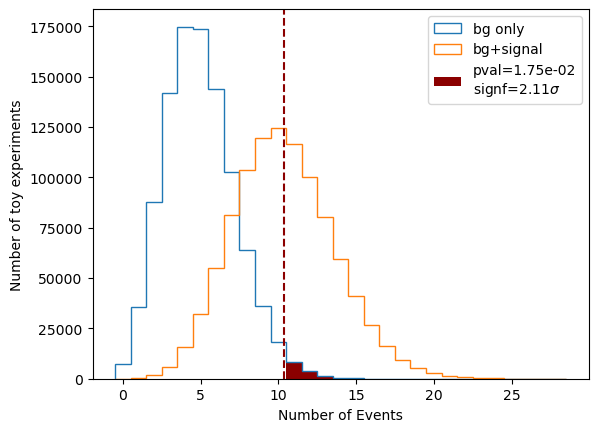

In [10]:
luminosity_factor = 1

total_exp_bg = np.sum(roi_bg_expected) * luminosity_factor
delta_bg = (np.sum(roi_bg_expected) * sigma_m + np.sum(roi_bg_expected) * sigma_p)/2

total_exp_higgs = np.sum(roi_higgs_expected) * luminosity_factor
total_exp_bgsig = total_exp_bg + total_exp_higgs

print(total_exp_bg, delta_bg)
print(f"total expected if only bg = [{total_exp_bg-delta_bg:.2f}, {total_exp_bg+delta_bg:.2f}]")
print(f"total expected if bg + sig = [{total_exp_bgsig-delta_bg:.2f}, {total_exp_bgsig+delta_bg:.2f}]")

# randomly sample a "lambda" i.e. expected count given a model
sampled_bgonly = np.random.normal(total_exp_bg, delta_bg, 1000_000)
sampled_bgsig = np.random.normal(total_exp_bgsig, delta_bg, 1000_000)

# sample random numbers
random_poisson_bgonly = ss.poisson(sampled_bgonly).rvs()
random_poisson_bgsig = ss.poisson(sampled_bgsig).rvs()

# plot
plt.hist(random_poisson_bgonly, bins=np.arange(0,30), histtype='step', label="bg only", align='left')
plt.hist(random_poisson_bgsig, bins=np.arange(0,30), histtype='step', label="bg+signal", align='left')
plt.axvline(total_exp_bgsig, color='darkred', ls='--')
pval = ss.poisson(total_exp_bg).pmf(int(total_exp_bgsig))
sigma = pvaltosigma(pval)
plt.hist(random_poisson_bgonly[random_poisson_bgonly>=total_exp_bgsig],
         bins=np.arange(0,30), color='darkred', label=f"pval={pval:.2e}\n"+fr"signf={sigma:.2f}$\sigma$", align='left')
plt.xlabel("Number of Events"); plt.ylabel("Number of toy experiments")
plt.legend();

So this means, after running many toy monte carlos, we see that our expected significance with the scaled background model (using side band fits) is 2.11 sigma for the given exposure. <br>

We can further investigate what exposure (luminosity) we need, or what cross-section for Higgs we need to get at least 5 sigma detection.

Now our model and the Poisson likelihood is the following<br>

$$-2\log(L) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}| \mu\cdot f_{bin}^{Higgs} + \alpha\cdot f_{bin}^{SM}))$$<br>

with $$\alpha = 1.11^{+0.075}_{-0.063}$$<br>

This time we try to fit the best $\mu$ value which can be read as the Higgs cross-section

0.8430522967178653 2.2836355206002485


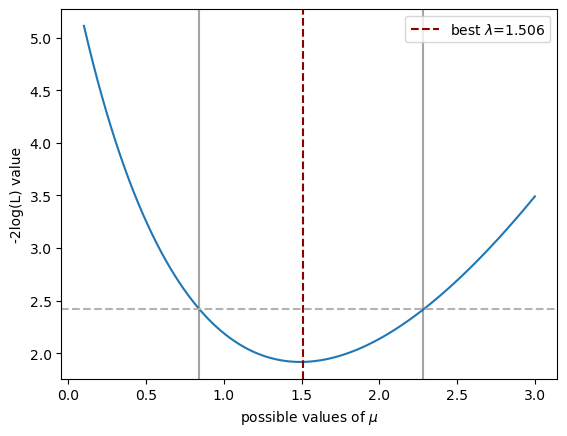

In [11]:
def get_nll(observed, expected):
    p = ss.poisson.pmf(k=observed.astype(int), mu=expected)
    return -2*np.sum(np.log10(p))

mu_values = np.linspace(0.1,3,100)
expected_values = np.array([np.sum(mu*roi_higgs_expected + roi_bg_expected) for mu in mu_values])
nll = np.array([get_nll(np.sum(roi_observed_data), exv) for exv in expected_values])
best_mu = mu_values[np.where(nll==np.min(nll))[0]][0]

# find out the error
intercept1 = interp1d(nll[mu_values<1.5], mu_values[mu_values<1.5])(np.min(nll) + 1/2) #[0]
intercept2 = interp1d(nll[mu_values>1.5], mu_values[mu_values>1.5])(np.min(nll) + 1/2) #[0]
print(intercept1, intercept2)
sigma_minus = (best_mu - intercept1)
sigma_plus = (intercept2 - best_mu)

plt.plot(mu_values, nll)
plt.axvline(best_mu, color='darkred', ls='--', label=fr'best $\lambda$={np.round(best_mu,3)}')
plt.axvline(intercept1, color='0.3', alpha=0.5)
plt.axvline(intercept2, color='0.3', alpha=0.5)
plt.axhline(np.min(nll)+0.5, color='0.7', ls="--")

plt.legend();
plt.xlabel(r'possible values of $\mu$')
plt.ylabel(r'-2log(L) value');

In [12]:
best_mu, sigma_minus, sigma_plus

(1.506060606060606, 0.6630083093427408, 0.7775749145396424)

Now we also found out that $$\hat{\mu} = 1.506^{+0.778}_{-0.663}$$

Let's try to fit both of them together in the equation;
$$-2\log(L) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}| \mu\cdot f_{bin}^{Higgs} + \alpha\cdot f_{bin}^{SM}))$$<br>

In [100]:
mu_values = np.linspace(0.9, 1.6, 1000)
alpha_values = np.linspace(0.9, 1.6, 1000)
total_obs_data = np.sum(roi_observed_data)

def func(mu, alf, fHiggs=roi_higgs_expected, fSM=roi_bg_expected):
    return (mu*fHiggs) + (alf*fSM)

nll_arr = np.zeros((len(mu_values), len(alpha_values), 1))

for i, m in tqdm(enumerate(mu_values), total=len(mu_values)):
    for j, a in enumerate(alpha_values):
        expected = func(m,a)
        nll_arr[i,j,:] = get_nll(total_obs_data, np.sum(expected))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [101]:
best_mu_index, best_alpha_index, _ = np.where(nll_arr==np.min(nll_arr))
best_mu_index, best_alpha_index = best_mu_index[0], best_alpha_index[0]

best_mu, best_alpha = mu_values[best_mu_index], alpha_values[best_alpha_index]

Text(0, 0.5, '$\\alpha$ - values')

/home/kara-unix/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


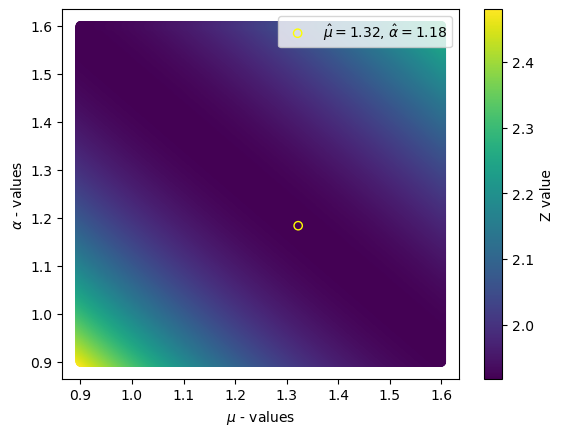

In [102]:
X, Y = np.meshgrid(mu_values, alpha_values)
# plt.contourf(X, Y, nll_arr[:,:,0], cmap='viridis')
# plt.colorbar(label='NLL value')

# Flatten X1, X2, and Z for plotting
flat_X1 = X.flatten()
flat_X2 = Y.flatten()
flat_Z = nll_arr.reshape(-1, 1)

# Scatter plot with color-coded Z values
plt.scatter(flat_X1, flat_X2, c=flat_Z[:, 0], cmap='viridis', marker='o') #, norm=LogNorm())
plt.colorbar(label='Z value')

plt.scatter(best_mu, best_alpha, marker='o', fc='none', ec='yellow', 
            label=fr'$\hat{{\mu}}=${best_mu:.2f}, $\hat{{\alpha}}=${best_alpha:.2f}')
plt.legend();
# Set axis labels
plt.xlabel(r'$\mu$ - values')
plt.ylabel(r'$\alpha$ - values')

So that we can comclude the best model describing our dataset is <br>

$$\text{Poisson}(N_{bin}^{data}| 1.32\cdot f_{bin}^{Higgs} + 1.18\cdot f_{bin}^{SM}))$$<br>

Next we look into what we can do beyond simple counting following the workshop notes. <br>
We will investigate test statistic and ordering using "likelihood ratio test-statistic".